# Сверточные нейронные сети (ноутбук)

> Знакомимся со сверточными нейронными сетями. Учимся решать задачу классификации изображений.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms.v2 as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

## Загрузка изображения

Загрузим изображение из интернета, например, Питер Гриффина из одноименного мультсериала "Гриффины".

In [2]:
! wget "https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200" -O peter.jpg

--2023-10-23 12:12:57--  https://static.independent.co.uk/2021/10/29/14/newFile-8.jpg?width=1200
Resolving static.independent.co.uk (static.independent.co.uk)... 146.75.117.91, 2a04:4e42:8d::347
Connecting to static.independent.co.uk (static.independent.co.uk)|146.75.117.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112326 (110K) [image/jpeg]
Saving to: ‘peter.jpg’

peter.jpg           100%[===================>] 109.69K  --.-KB/s    in 0.07s   

2023-10-23 12:12:58 (1.48 MB/s) - ‘peter.jpg’ saved [112326/112326]



## Чтение изображения

In [3]:
img = Image.open('peter.jpg')

In [4]:
img.format

'JPEG'

In [5]:
img.size

(1200, 899)

In [6]:
img.mode

'RGB'

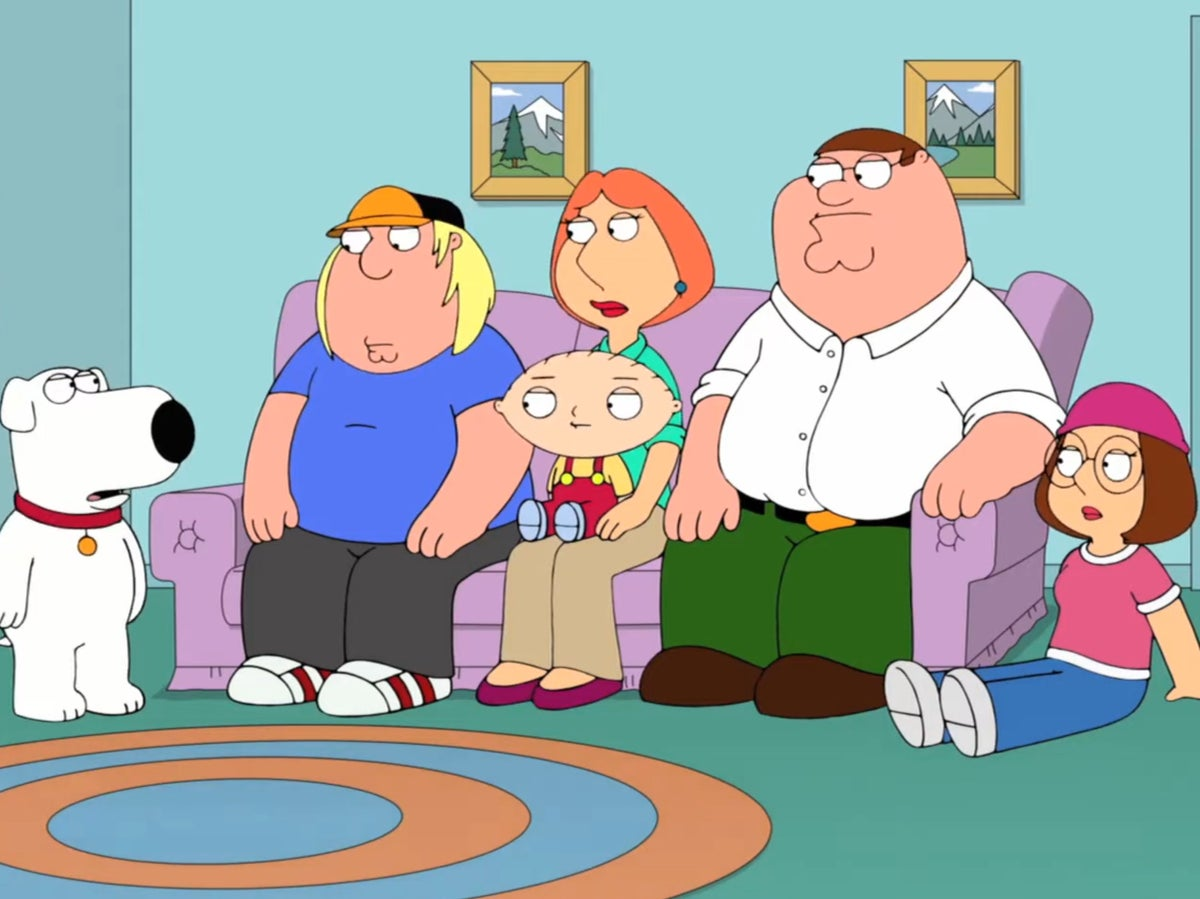

In [7]:
img

## Матричное представление

In [8]:
img_matrix = np.array(img)

In [9]:
img_matrix.shape

(899, 1200, 3)

In [10]:
img_matrix

array([[[142, 190, 194],
        [142, 190, 194],
        [142, 190, 194],
        ...,
        [157, 218, 219],
        [157, 218, 219],
        [157, 218, 219]],

       [[142, 190, 194],
        [142, 190, 194],
        [142, 190, 194],
        ...,
        [157, 218, 219],
        [157, 218, 219],
        [157, 218, 219]],

       [[142, 190, 194],
        [142, 190, 194],
        [142, 190, 194],
        ...,
        [158, 218, 219],
        [158, 218, 219],
        [158, 218, 219]],

       ...,

       [[121, 172, 201],
        [121, 172, 201],
        [121, 172, 201],
        ...,
        [ 91, 165, 152],
        [ 91, 165, 152],
        [ 91, 165, 152]],

       [[121, 172, 201],
        [121, 172, 201],
        [121, 172, 201],
        ...,
        [ 91, 165, 152],
        [ 91, 165, 152],
        [ 91, 165, 152]],

       [[121, 172, 201],
        [121, 172, 201],
        [121, 172, 201],
        ...,
        [ 91, 165, 152],
        [ 91, 165, 152],
        [ 91, 165, 152]]

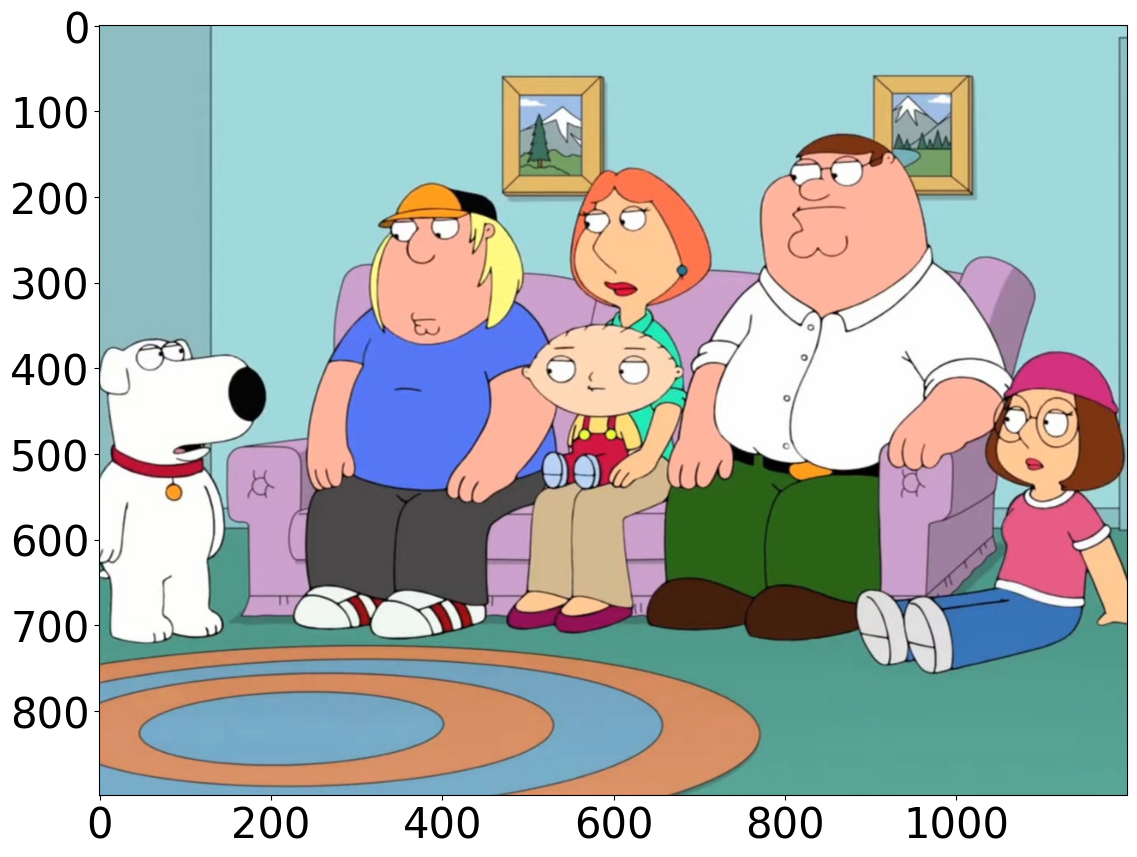

In [11]:
plt.figure(figsize=(20, 10))

plt.imshow(img_matrix)

plt.show()

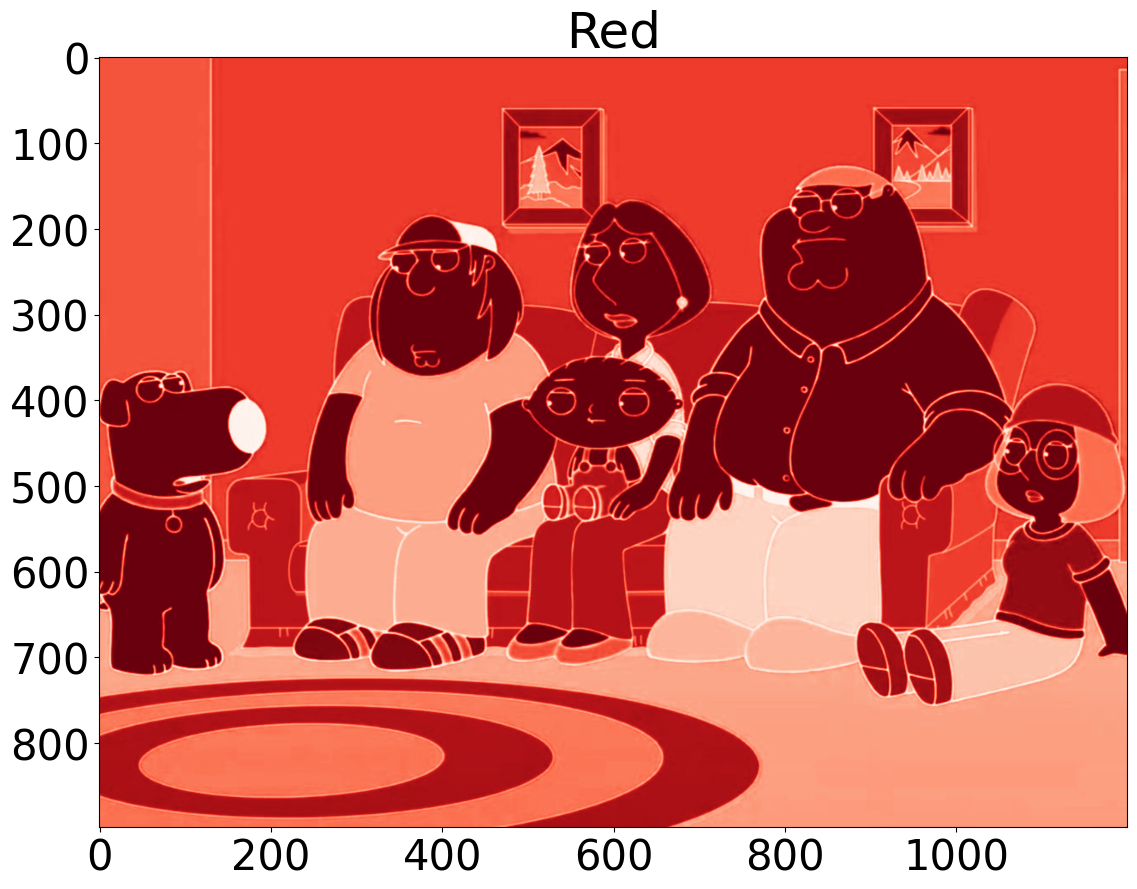

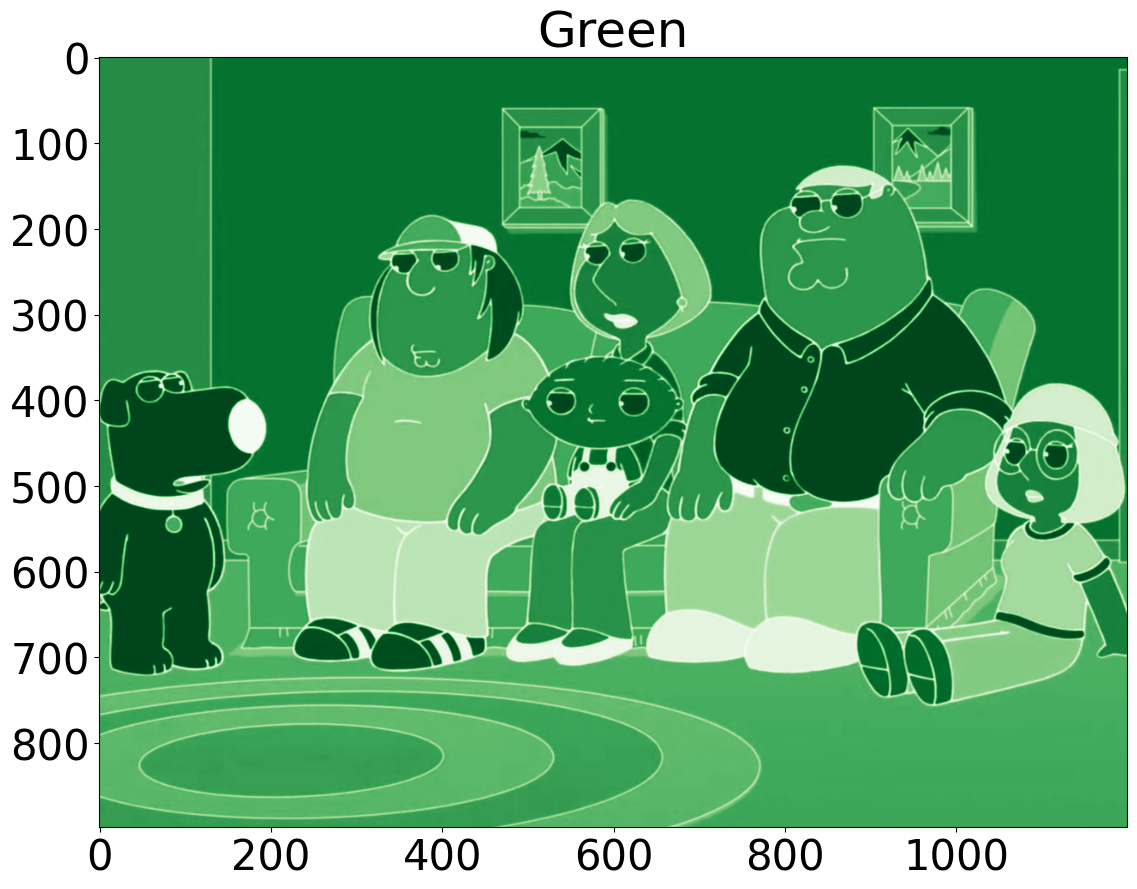

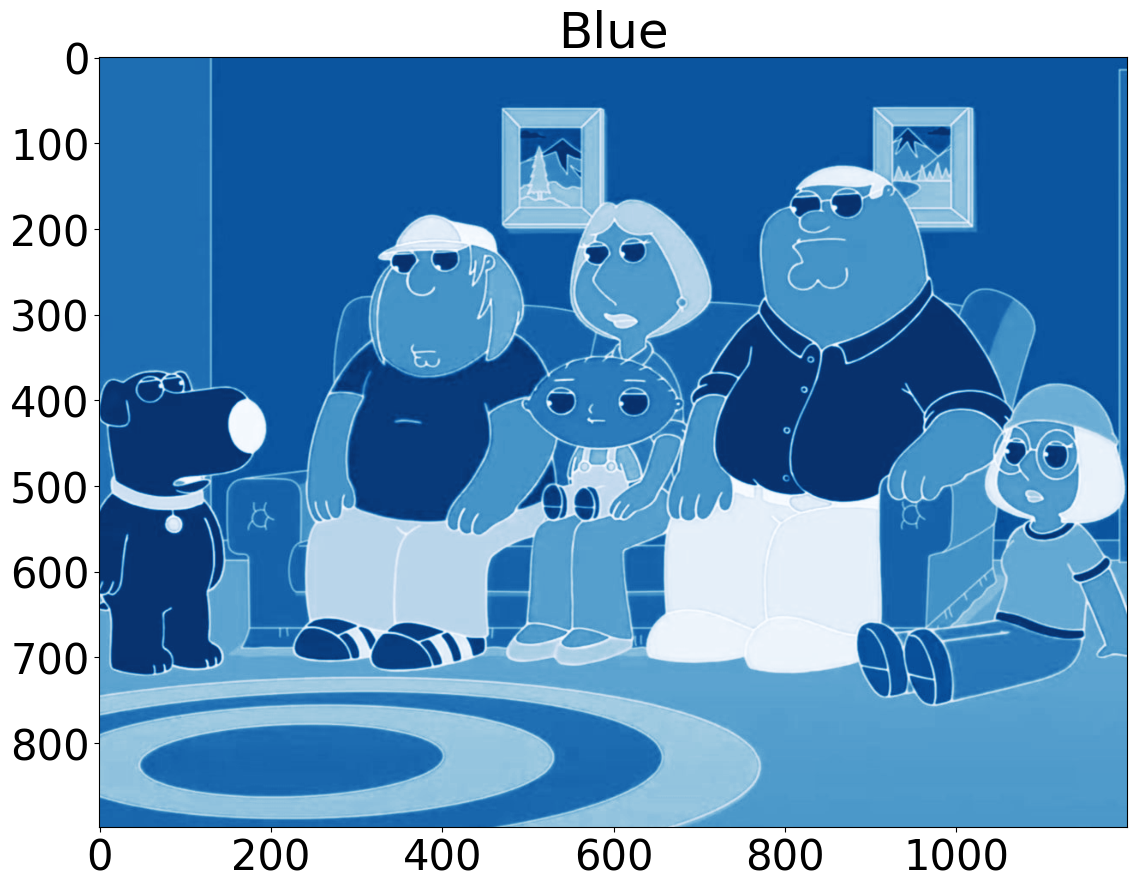

In [12]:
for i, (cmap, color) in enumerate(
    zip(
        [cm.Reds, cm.Greens, cm.Blues],
        ['Red', 'Green', 'Blue']
    )
):
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matrix[:, :, i], cmap=cmap)
    plt.title(color)
    plt.show()

In [13]:
img_matrix[:, :, 0].min(), img_matrix[:, :, 0].max()

(0, 255)

## Свертка

Свертка в `PyTorch` представлена модулем `nn.Conv2d` со следующими параметрами:

- in_channels (int) – Количество каналов во входном изображении

- out_channels (int) – Количество каналов в выходном изображении

- kernel_size (int or tuple) – Размер ядра свертки

- stride (int or tuple, optional) – Страйд (шаг ядра свертки). По умолчанию: 1

- padding (int, tuple or str, optional) – Размер паддинга. По умолчанию: 0

- padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. По умолчанию: 'zeros'

- dilation (int or tuple, optional) – Дилейшн (шаг между элементами внутри ядра). По умолчанию: 1

- bias (bool, optional) – добавлять ли обучаемый сдвиг. По умолчанию: True

In [ ]:
x -> z_1 -> z_2 -> ... -> z_n (y^hat)

x -> z_1 

(100, 100, 3) -> (m, m, C)

(102, 102, 3) 

In [14]:
conv1 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3
)

In [15]:
img_tensor = T.ToTensor()(img).unsqueeze(0)

In [16]:
img_tensor

tensor([[[[0.5569, 0.5569, 0.5569,  ..., 0.6157, 0.6157, 0.6157],
          [0.5569, 0.5569, 0.5569,  ..., 0.6157, 0.6157, 0.6157],
          [0.5569, 0.5569, 0.5569,  ..., 0.6196, 0.6196, 0.6196],
          ...,
          [0.4745, 0.4745, 0.4745,  ..., 0.3569, 0.3569, 0.3569],
          [0.4745, 0.4745, 0.4745,  ..., 0.3569, 0.3569, 0.3569],
          [0.4745, 0.4745, 0.4745,  ..., 0.3569, 0.3569, 0.3569]],

         [[0.7451, 0.7451, 0.7451,  ..., 0.8549, 0.8549, 0.8549],
          [0.7451, 0.7451, 0.7451,  ..., 0.8549, 0.8549, 0.8549],
          [0.7451, 0.7451, 0.7451,  ..., 0.8549, 0.8549, 0.8549],
          ...,
          [0.6745, 0.6745, 0.6745,  ..., 0.6471, 0.6471, 0.6471],
          [0.6745, 0.6745, 0.6745,  ..., 0.6471, 0.6471, 0.6471],
          [0.6745, 0.6745, 0.6745,  ..., 0.6471, 0.6471, 0.6471]],

         [[0.7608, 0.7608, 0.7608,  ..., 0.8588, 0.8588, 0.8588],
          [0.7608, 0.7608, 0.7608,  ..., 0.8588, 0.8588, 0.8588],
          [0.7608, 0.7608, 0.7608,  ..., 0

In [17]:
img_tensor.shape

torch.Size([1, 3, 899, 1200])

In [18]:
output = conv1(img_tensor)

In [19]:
output.shape

torch.Size([1, 10, 897, 1198])

In [20]:
conv2 = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=3,
    padding=1
)

In [21]:
output = conv2(img_tensor)

In [22]:
output.shape

torch.Size([1, 10, 899, 1200])

In [23]:
output

tensor([[[[ 0.1061, -0.0969, -0.0969,  ..., -0.0989, -0.0989, -0.3941],
          [ 0.0921, -0.0233, -0.0233,  ..., -0.0161, -0.0161, -0.2254],
          [ 0.0921, -0.0233, -0.0233,  ..., -0.0163, -0.0163, -0.2261],
          ...,
          [ 0.0816,  0.0077,  0.0077,  ..., -0.0530, -0.0530, -0.1769],
          [ 0.0816,  0.0077,  0.0077,  ..., -0.0521, -0.0521, -0.1771],
          [ 0.0099, -0.0337, -0.0337,  ..., -0.0646, -0.0646, -0.0523]],

         [[-0.2441, -0.3818, -0.3818,  ..., -0.4254, -0.4254, -0.4667],
          [-0.3252, -0.4473, -0.4473,  ..., -0.4971, -0.4971, -0.5117],
          [-0.3252, -0.4473, -0.4473,  ..., -0.4967, -0.4967, -0.5118],
          ...,
          [-0.3523, -0.4424, -0.4424,  ..., -0.3827, -0.3827, -0.3898],
          [-0.3523, -0.4424, -0.4424,  ..., -0.3831, -0.3831, -0.3891],
          [-0.0718, -0.2060, -0.2060,  ..., -0.1691, -0.1691, -0.3131]],

         [[ 0.4853,  0.4545,  0.4545,  ...,  0.4818,  0.4818,  0.1244],
          [ 0.3706,  0.2351,  

In [26]:
conv2.weight.shape

torch.Size([10, 3, 3, 3])

In [28]:
conv2.bias.shape

torch.Size([10])

## Пулинг

Пулинг представлен в модуле `torch.nn`, в основном будем использовать `MaxPool2d` и `AvgPool2d`.

Параметры:

- kernel_size – размер окошка

- stride – страйд окошка. По умолчанию равен kernel_size

- padding – сколько нулевого паддинга добавлять по краям. По умолчанию: 0.

In [29]:
img_tensor = torch.randint(0, 10, size=(10, 10), dtype=torch.float32).unsqueeze(0)

In [30]:
img_tensor

tensor([[[4., 3., 0., 8., 4., 0., 0., 8., 0., 9.],
         [8., 7., 9., 5., 7., 1., 7., 2., 9., 9.],
         [2., 3., 8., 3., 0., 7., 7., 2., 2., 6.],
         [9., 1., 1., 6., 2., 3., 8., 0., 4., 6.],
         [2., 9., 7., 2., 4., 2., 3., 1., 1., 2.],
         [8., 5., 6., 3., 0., 8., 0., 7., 7., 9.],
         [0., 8., 4., 3., 5., 5., 7., 2., 4., 5.],
         [6., 9., 4., 7., 5., 5., 5., 3., 2., 8.],
         [4., 0., 8., 4., 1., 5., 4., 9., 3., 2.],
         [9., 9., 8., 4., 0., 9., 2., 3., 6., 8.]]])

In [31]:
pooling1 = nn.MaxPool2d(kernel_size=2)

In [32]:
pooling1(img_tensor)

tensor([[[8., 9., 7., 8., 9.],
         [9., 8., 7., 8., 6.],
         [9., 7., 8., 7., 9.],
         [9., 7., 5., 7., 8.],
         [9., 8., 9., 9., 8.]]])

In [33]:
pooling2 = nn.AvgPool2d(kernel_size=2)

In [34]:
pooling2(img_tensor)

tensor([[[5.5000, 5.5000, 3.0000, 4.2500, 6.7500],
         [3.7500, 4.5000, 3.0000, 4.2500, 4.5000],
         [6.0000, 4.5000, 3.5000, 2.7500, 4.7500],
         [5.7500, 4.5000, 5.0000, 4.2500, 4.7500],
         [5.5000, 6.0000, 3.7500, 4.5000, 4.7500]]])

## Датасет MNIST

In [35]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
)

In [36]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../datasets/mnist
    Split: Train

In [37]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [38]:
mnist_train.test_labels.shape

torch.Size([60000])

In [39]:
mnist_train[0][0]

In [ ]:
60000 * 784 * float32

224 * 224 * 3 * 100_000 * float32

In [ ]:
/ <- [path1, path2, ..., path_n]

path1 -> img1 -> tensor1

In [40]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)

In [41]:
mnist_valid = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [42]:
len(mnist_train)

60000

In [43]:
len(mnist_valid)

10000

In [44]:
mnist_train[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [45]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

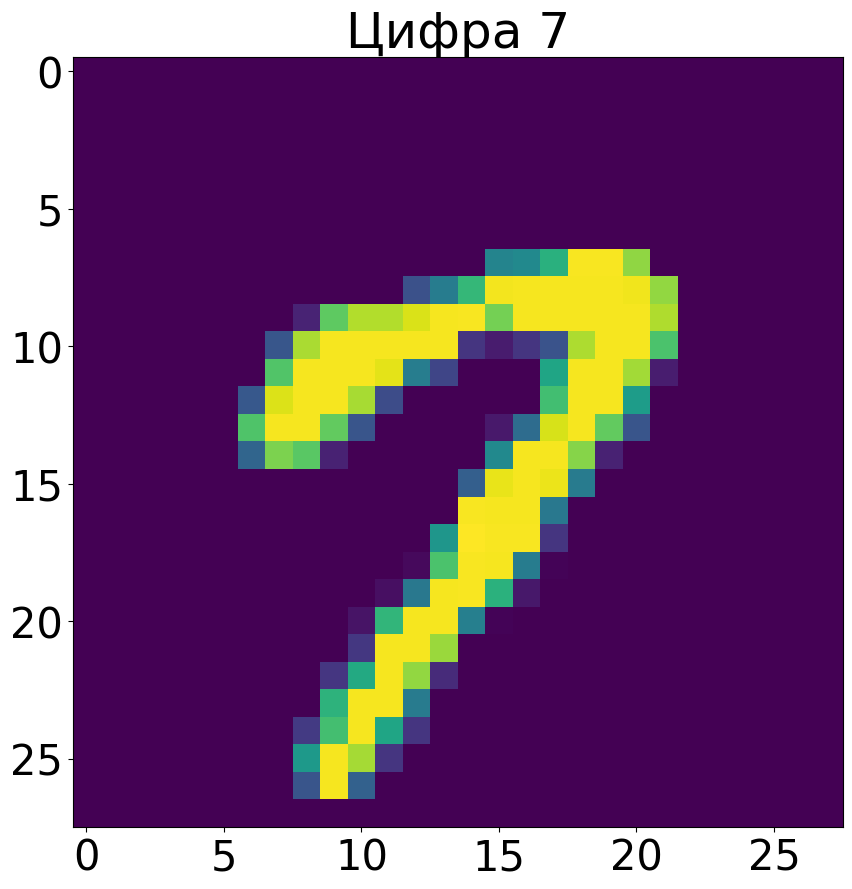

In [46]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[15][1]}')
plt.imshow(mnist_train[15][0][0])

plt.show()

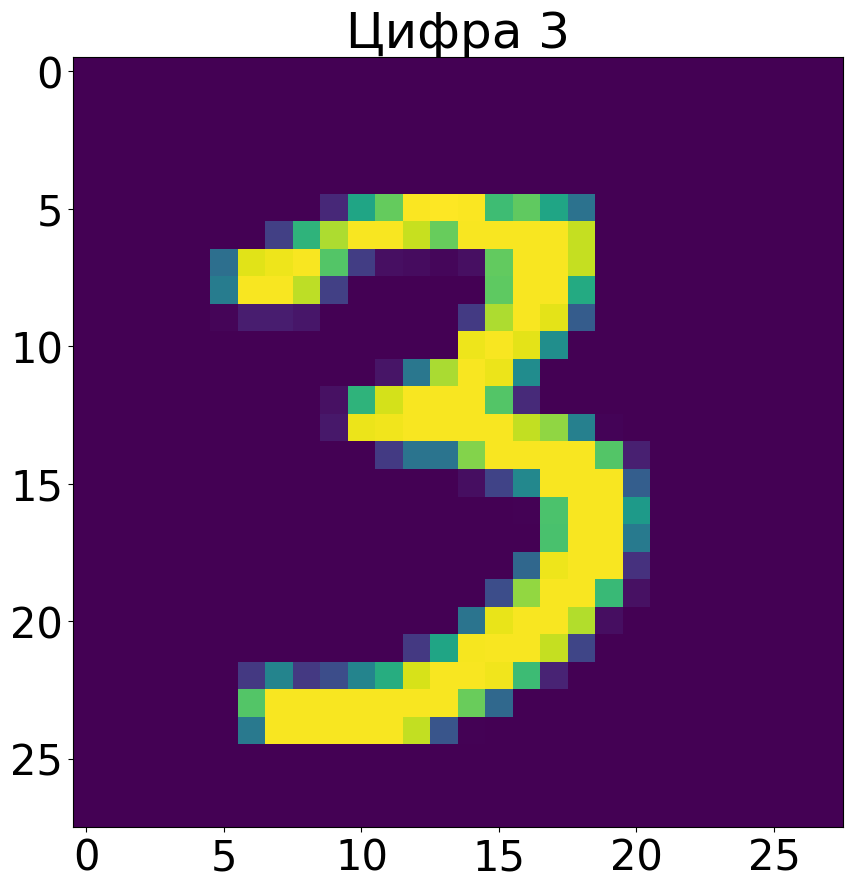

In [47]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {mnist_train[10000][1]}')
plt.imshow(mnist_train[10000][0][0])

plt.show()

## Полносвязная нейронная сеть

Обучим полносвязную нейронную сеть на датасете MNIST.

In [48]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn):
    model.train()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()
        
        total_correct += (output.argmax(dim=1) == y).sum().item()

        optimizer.step()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [49]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn):
    model.eval()

    total_loss = 0
    total_correct = 0

    for x, y in tqdm(data_loader):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        total_correct += (output.argmax(dim=1) == y).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='darkgrid')


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()
    
    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()

    plt.show()

In [51]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [ ]:
(28, 28) -> (784)

In [52]:
first_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

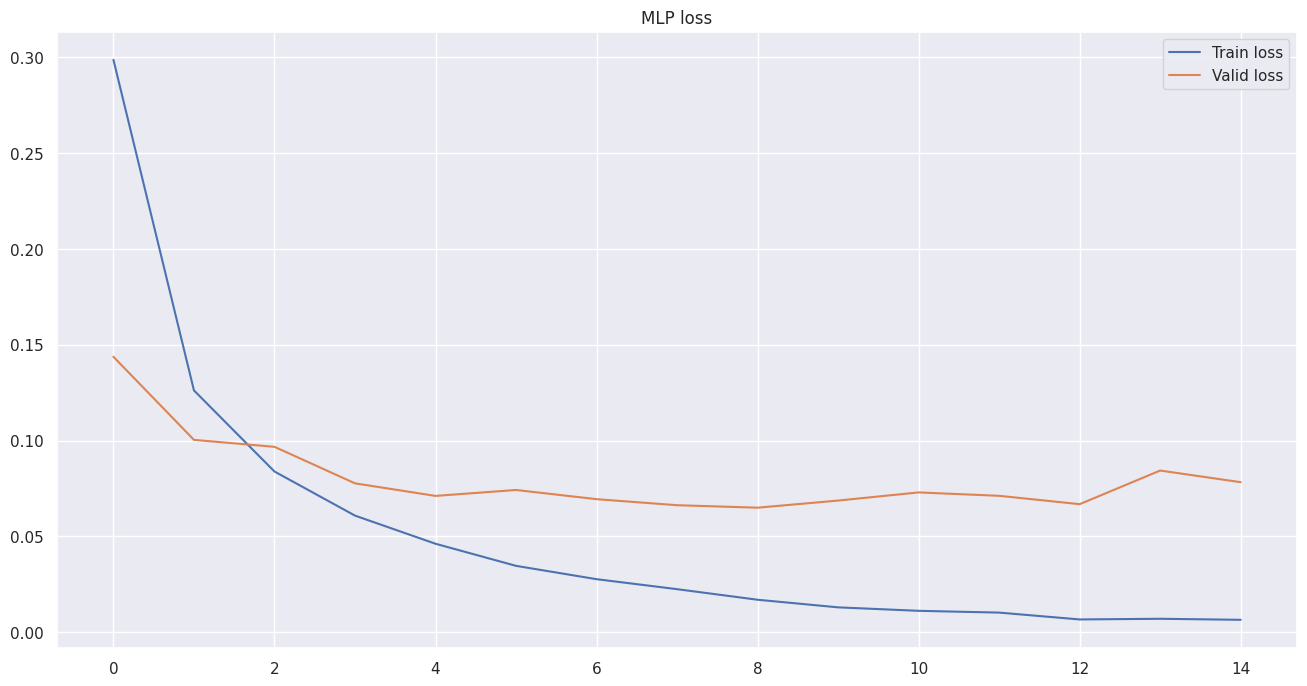

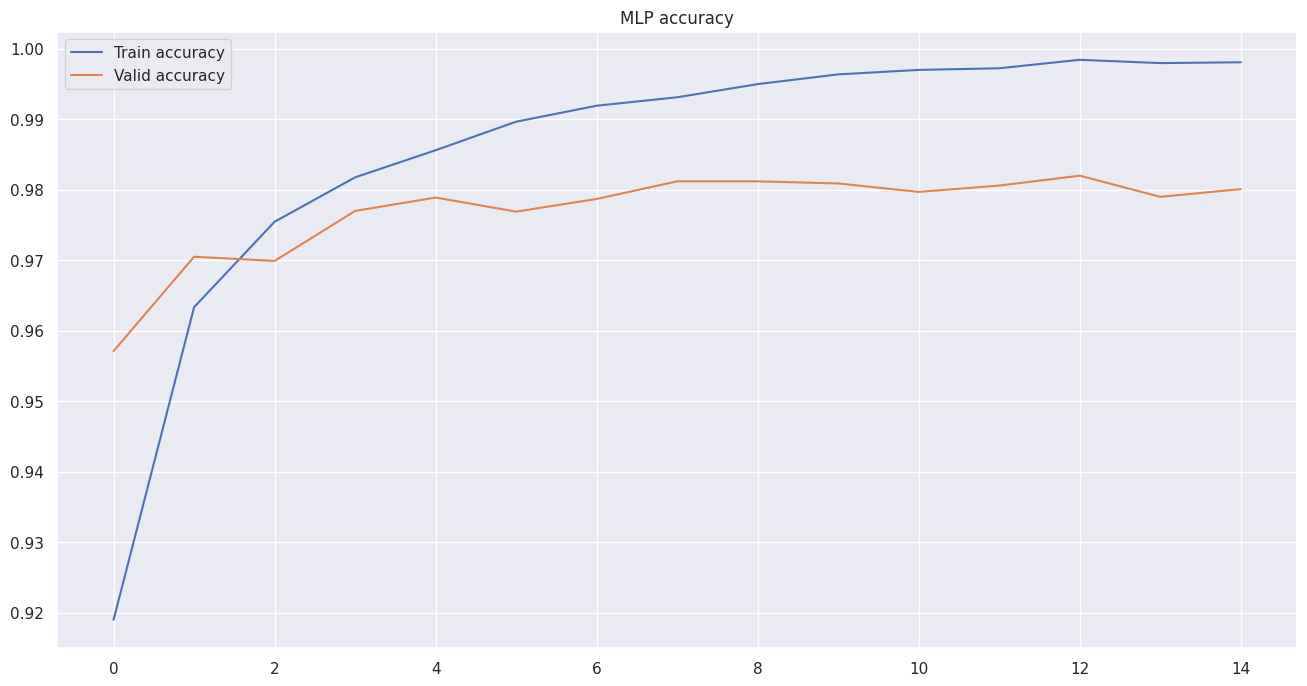

In [53]:
fit(first_model, train_loader, valid_loader, optimizer, loss_fn, 15, 'MLP')

## Сверточная сеть

In [62]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),  # 28 x 28 -> 24 x 24
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2),  # 24 x 24 -> 12 x 12

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5),  # 12 x 12 -> 8 x 8
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=2),  # 8 x 8 -> 4 x 4

    nn.Flatten(),  # 4 x 4 x 16 -> 4 * 4 * 16
    nn.Linear(4 * 4 * 16, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

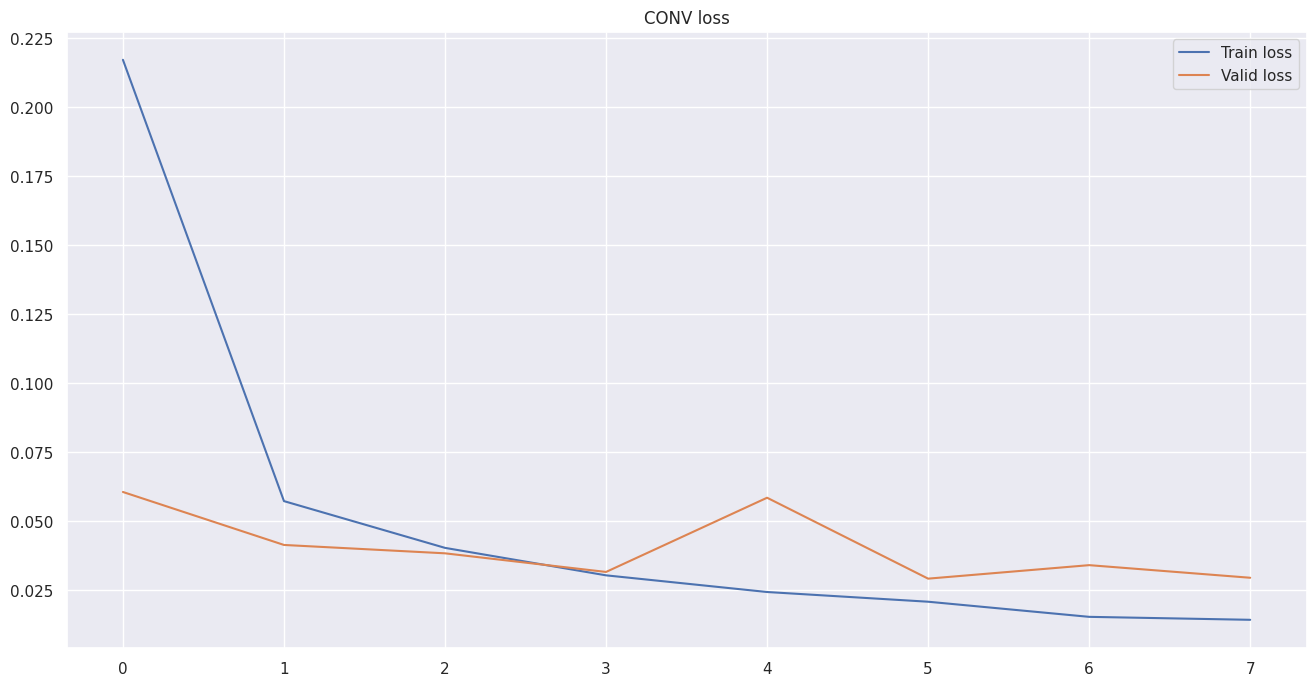

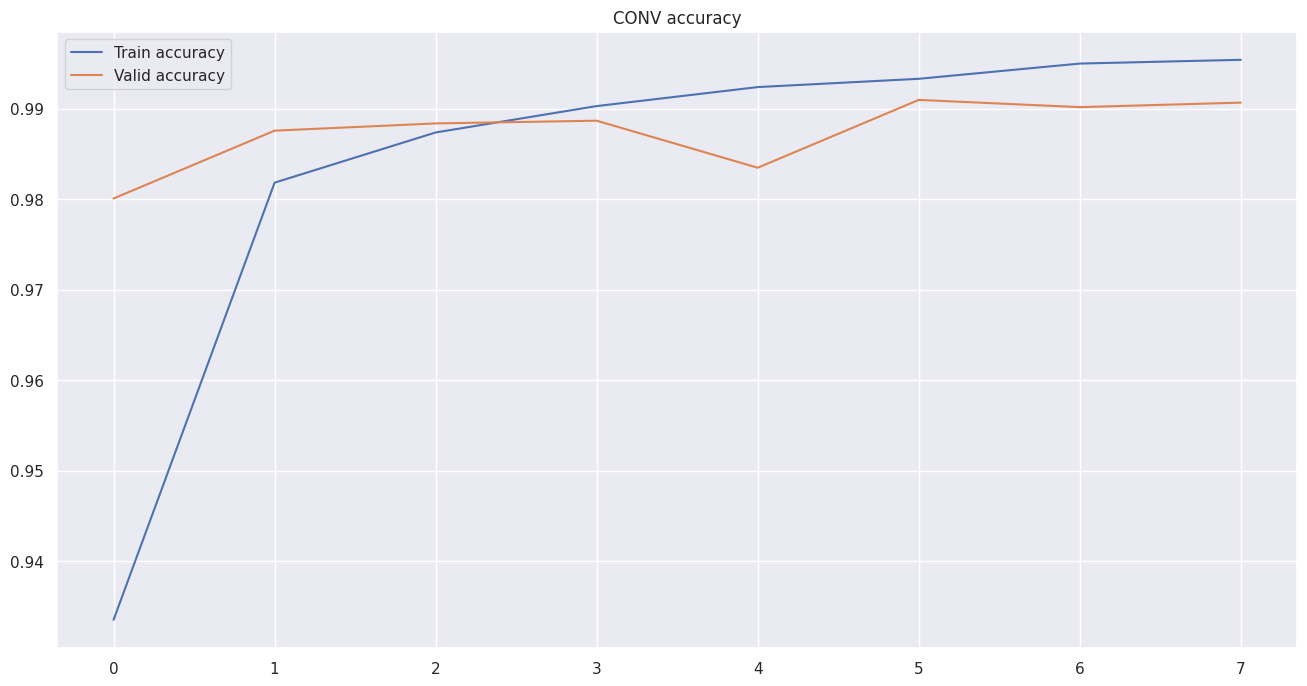

 92%|█████████▏| 860/938 [00:05<00:00, 153.11it/s]


KeyboardInterrupt: 

In [63]:
fit(second_model, train_loader, valid_loader, optimizer, loss_fn, 15, 'CONV')